In [21]:
import time
import json
from functools import wraps
from datetime.datetime import strptime
from datetime.date import today
from dateutil.relativedelta import relativedelta

import vk
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp

import numpy as np
from numpy.linalg import norm

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [2]:
cache_filename = 'graph_vertex_cache.json'

In [3]:
with open("author.txt") as f:
    login = f.readline().rstrip()
    passwd = f.readline().rstrip()

session = vk.AuthSession(app_id='6070120', user_login=login, user_password=passwd)

api = vk.API(session)
api_version = "5.73"

### Load graph dictionary from file if possible

In [4]:
try:
    cache_dict = json.load(open(cache_filename, 'r'))
except FileNotFoundError:
    cache_dict = {}
    
cache_dict = {int(k): val for k, val in cache_dict.items()}

### Construct a graph

In [22]:
# decorator that handles sleeping
def vk_requester(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        global requests_count
        if requests_count == 3:
            requests_count = 0
            time.sleep(1)
        try:
            requests_count += 1
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code in (6, 10): # too many requests per second or internal server error
                time.sleep(1)
                requests_count += 1
                return_val = request_func(*args, **kwargs)
            else:
                raise err
        return return_val
    return wrapper

In [72]:
def request_list(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        return_val = request_func(*args, **kwargs)
        if isinstance(return_val, list):
            return return_val
        else:
            return list(return_val['items'])
    return wrapper

def handle_friends_exceptions(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        try:
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code == 18: # deleted or banned user
                return_val = []
            else:
                raise err
        return return_val
    return wrapper

In [73]:
@request_list
@handle_friends_exceptions
@vk_requester
def get_friends(api, api_version, user_id):
    return api.friends.get(user_id=user_id, v=api_version)

In [59]:
def construct_graph(user_id, output_graph, api, waves=3):
    output_graph.add_node(user_id)
    
    global nodes_waves
    nodes_waves[waves].append(user_id)
    
    if waves != 0:
        # request friends
        global cache_dict

        if user_id in cache_dict:
            friends = cache_dict[user_id]
        else:
            #print("{} not found in cache".format(user_id))
            friends = get_friends(api, api_version, user_id)
            cache_dict[user_id] = friends

        # add each friendship and dive deeper
        for friend in friends:
            if waves != 0 and friend not in output_graph.nodes():
                construct_graph(friend, output_graph, api, waves - 1)
            output_graph.add_edge(user_id, friend)


In [8]:
class MyCoolException(Exception):
    pass

In [ ]:
%%time
requests_count = 0
main_graph = nx.Graph()
start_id = 10938483 # my id
waves = 4
nodes_waves = {wave: [] for wave in range(waves + 1)}

while True:
    try:
        construct_graph(start_id, main_graph, api, waves)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

            
#graph_from_cache(start_id, main_graph)

nodes_waves = {waves - key: val for key, val in nodes_waves.items()}

In [74]:
len(main_graph.nodes())

5695650

In [77]:
'''
with open(cache_filename, 'w') as f:
    json.dump(cache_dict, f)
'''

In [76]:
len(nodes_waves[1])

21

In [66]:
def graph_from_cache(user_id, output_graph, waves=3):
    output_graph.add_node(user_id)
    if waves == 0:
        return
    
    if user_id in cache_dict:
        friends = cache_dict[user_id]
        for friend in friends:
            if friend not in output_graph.nodes():
                graph_from_cache(friend, output_graph, waves - 1)
            output_graph.add_edge(user_id, friend)

In [67]:
%%time
graph_3waves = nx.Graph()
graph_from_cache(start_id, graph_3waves, waves=3)

CPU times: user 612 ms, sys: 48.3 ms, total: 661 ms
Wall time: 750 ms


In [75]:
len(graph_3waves)

171253

### Visualize the graph

In [ ]:
%%time
pos=nx.spring_layout(graph_3waves)

In [70]:
colors = ['#f20000', '#f0e000', '#097505', '#07edb3', '#0791ed', '#0716ed', '#9d08a8']

2 #097505
1 #f0e000
0 #f20000
CPU times: user 1.39 s, sys: 308 ms, total: 1.7 s
Wall time: 1.3 s


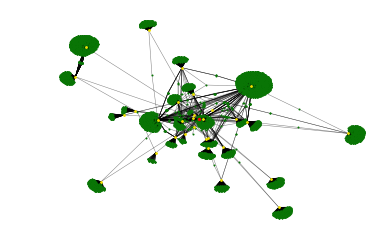

In [14]:
%%time
#nx.draw(main_graph, pos=pos, node_color='pink', edge_color='black', node_size=1)

for wave, nodes in sorted(nodes_waves.items(), reverse=True):
    print(wave, colors[wave])
    nx.draw_networkx_nodes(main_graph, pos, nodelist=nodes, node_color=colors[wave], node_size=5 - 2 * wave)
nx.draw_networkx_edges(main_graph, pos, width=0.5, alpha=0.5)

plt.axis('off')
plt.savefig("graph.pdf", orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1) 


### Form dataset from graph nodes

In [44]:
@vk_requester
def get_users(api, api_version, user_ids, fields):
    return api.users.get(user_ids=user_ids, fields=fields, v=api_version)

In [78]:
@request_list
@vk_requester
def get_groups(api, api_version, user_ids, fields):
    return api.groups.get(user_ids=user_ids, extended=1, fields=fields, v=api_version)

In [ ]:
features_fields = ['uid', 'first_name', 'last_name', 'deactivated', 
                   'bdate', 'city', 'country', 'home_town', 
                   'universities', 'schools', 'relation', 'counters']
counters = ['audios', 'friends', 'photos', 'videos', 'groups']

features = ['first_name', 'last_name', 'is_active', 'age', 'education', 
            'has_age', 'has_education', 'has_location'] + list(map(lambda x: 'cnt_{}'.format(x), counters)) + ['avg_group_size']


node_ids = list(main_graph.nodes())
nodes_data = pd.DataFrame(index=node_ids, columns=features)
for node_id in node_ids:
    user = get_users(api, api_version, node_id, features_fields)

    # generate features from acquired fields
    if 'first_name' in user:
        nodes_data.loc[node_id, 'first_name'] = user['first_name']
    
    if 'last_name' in user:
        nodes_data.loc[node_id, 'last_name'] = user['last_name']
        
    if 'deactivated' in user:
        nodes_data.loc[node_id, 'is_active'] = 0
        
    if 'bdate' in user:
        nodes_data.loc[node_id, 'age'] = relativedelta(today(), strptime(user['bdate'], '%d.%m.%Y').date()).years
        nodes_data.loc[node_id, 'has_age'] = 1
    else:
        nodes_data.loc[node_id, 'has_age'] = 0
    
    if 'universities' in user:
        nodes_data.loc[node_id, 'education'] = 'higher'
        nodes_data.loc[node_id, 'has_education'] = 1
    elif 'schools' in user:
        nodes_data.loc[node_id, 'education'] = 'secondary'
        nodes_data.loc[node_id, 'has_education'] = 1
    else:
        nodes_data.loc[node_id, 'has_education'] = 0
        
    if any (field in user for field in ('city', 'country', 'home_town')):
        nodes_data.loc[node_id, 'has_location'] = 1
    else:
        nodes_data.loc[node_id, 'has_location'] = 0
        
    if 'counters' in user:
        for counter in counters:
            if counter in user['counters']:
                nodes_data.loc[node_id, 'cnt_{}'.format(counter)] = user['counters'][counter]
    
    groups = get_groups(api, api_version, node_id, fields=['gid', 'members_count'])
    groups = list(group['members_count'] for group in groups if 'members_count' in group)
    nodes_data.loc[node_id, 'avg_group_size'] = sum(groups) / len(groups)

### Apply clustering to the data

In [122]:
adjacency = nx.adjacency_matrix(main_graph)

In [ ]:
labels_nodes = {}
for label in a.labels_:
    labels_nodes[label] = [node_id for ind, node_id in enumerate(main_graph.nodes()) if a.labels_[ind] == label]

In [ ]:
%%time
#adjacency = smth
    
'''
silhouettes = {}
for k in range(2, 10):
    fit_clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    silhouettes[k] = (silhouette(k, adjacency, fit_clustering.labels_), fit_clustering)
'''

clusterings = []
for k in range(2, 10):
    cl = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    
    labels_nodes = {}
    for label in cl.labels_:
        labels_nodes[label] = [node_id for ind, node_id in enumerate(main_graph.nodes()) if cl.labels_[ind] == label]
    
    
print(max(clusterings, key = lambda clustering: silhouette_score(adjacency, clustering.labels_)))

In [49]:
clusterings

[SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=4, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=5, n_init=10, n_jobs=1,
           n_neighbors=

In [29]:
'''
DEPRECATED IN FAVOUR OF DECORATORS
'''
def get_friends_with_sleep(user_id):
    global requests_count
    if requests_count == 3: # avoid making too many requests
        requests_count = 0
        time.sleep(1)

    try:
        friends = api.friends.get(user_id=user_id, v=api_version)
        requests_count += 1
    except vk.exceptions.VkAPIError as err:
        if err.code in (6, 10): # too many requests per second or internal server error
            time.sleep(1)
            friends = get_friends_with_sleep(user_id)
        else:
            raise err
    if isinstance(friends, list):
        return friends
    return friends['items']

In [36]:
'''
DEPRECATED
'''

def silhouette(k_clusters, data, labels):
    
    s = []
    for vec_ind, vec in enumerate(data):
        vec_cluster = labels[vec_ind]
        b_i = []
        a_i = 0
        for cl_num in range(k_clusters):
            metric = np.average([norm(vec - cl_vec) for cl_vec_ind, cl_vec in enumerate(data) if labels[cl_vec_ind] == cl_num])
            if vec_cluster == cl_num:
                a_i = metric
            else:
                b_i.append(metric)
        b_i = min(b_i)
        
        s_i = (b_i - a_i) / max(a_i, b_i)
        s.append(s_i)
    
    return np.average(s)